In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [358]:
import datetime as dt
from scipy import stats, mean

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
#inspect existing columns
inspector = inspect(engine)


In [13]:
#check measurement columns
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
#check station columns
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
#check column data
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [20]:
#find last date in database

engine.execute('SELECT MAX(date) max_date FROM measurement').fetchall()

[('2017-08-23',)]

In [16]:
# Map classes
ME = Base.classes.measurement
ST = Base.classes.station

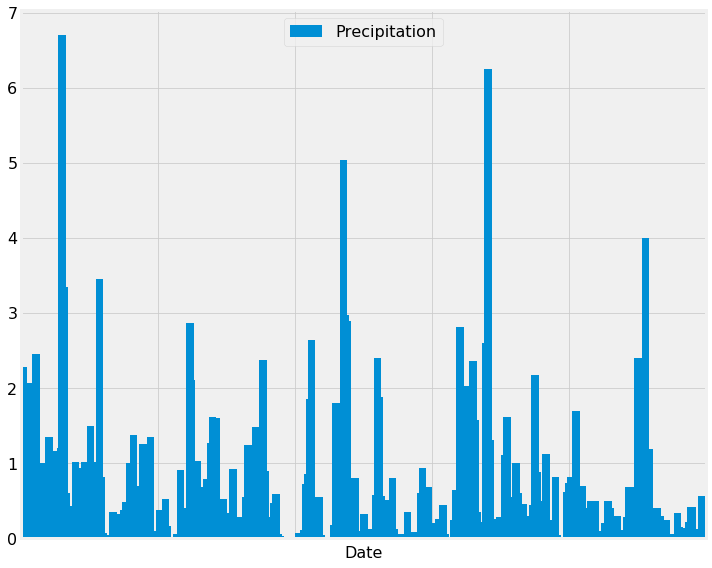

In [347]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

                                                                 
# Calculate the date 1 year ago from the last data point in the database

year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(ME.date,ME.prcp).filter(ME.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns=['Date','Precipitation'])

# Sort the dataframe by date
precip_df=precip_df.sort_values(by=['Date'])
precip_df= precip_df.reset_index(drop=True)

#percip_df.tail()
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10,8))
plt.grid(axis='both', alpha=0.8)
plt.bar(precip_df['Date'],precip_df['Precipitation'],width=4, label='Precipitation')
plt.xticks(np.arange(0, 365, step=73), labels=[])
plt.xlim(0,365)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.legend(loc=9, fontsize = 16)
plt.tight_layout()
plt.savefig('Charts/precip.png')
plt.show()

In [115]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [132]:
# Design a query to show how many stations are available in this dataset?
stn = session.query(ME.station).distinct()
print(f"There are {stn.count()} stations in the dataset")

There are 9 stations in the dataset


In [142]:
# # What are the most active stations? (i.e. what stations have the most rows)?
# # List the stations and the counts in descending order.
stn_count = session.query(ME.station,func.count(ME.station)).group_by(ME.station).order_by(func.count(ME.station).desc())
for station in stn_count:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [144]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(ME.tobs),func.max(ME.tobs),func.avg(ME.tobs)).filter(ME.date == 'USC00519281').first()

(54.0, 85.0, 71.66378066378067)

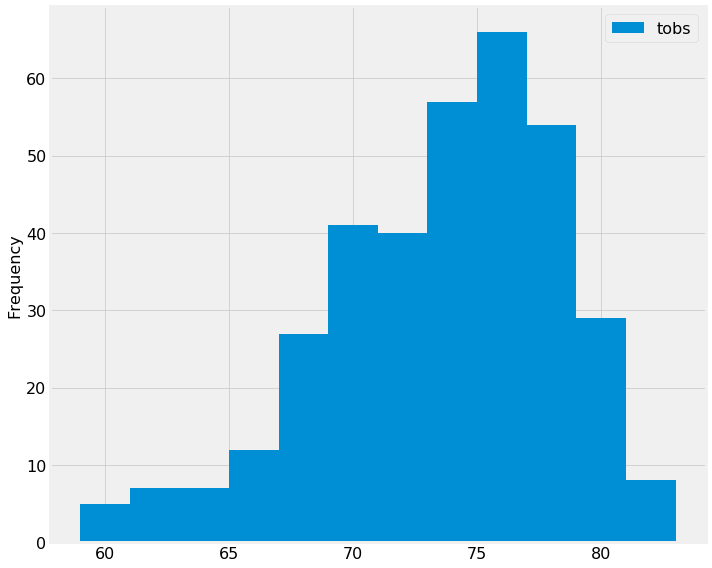

In [157]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(ME.date, ME.station, ME.tobs).filter(ME.date >= year_ago, ME.station == 'USC00519281' ).all()
temp_df = pd.DataFrame(temp, columns=['Date','Station','Temp'])
temp_df.head()
plt.figure(figsize=(10,8))
plt.hist(temp_df['Temp'],bins = 12, label="tobs")
plt.grid(axis='both', alpha=0.8)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(loc='best', fontsize = 16)
plt.tight_layout()
plt.savefig('Charts/tobs.png')
plt.show()

## Temperature Analysis 1
Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

You may either use SQLAlchemy or pandas's read_csv() to perform this portion.

Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [372]:
#get June and Dec tobs
june_temps = session.query(ME.tobs).filter(func.strftime("%d", ME.date) == "06").all()
dec_temps = session.query(ME.tobs).filter(func.strftime("%d", ME.date) == "12").all()


In [367]:
#check means
jun_mean = mean(june_temps)
dec_mean = mean(dec_temps)


print(f"Jun avg temperature is: {jun_mean}")
print(f"Dec avg temperature is: {dec_mean}")

Jun avg temperature is: 72.7361963190184
Dec avg temperature is: 72.91833590138675


In [369]:
#perform independent t-test
stats.ttest_ind(june_temps, dec_temps)

Ttest_indResult(statistic=array([-0.72330178]), pvalue=array([0.46962471]))

In [378]:
print("The p-value if well above 0.05, so we can not reject the null hypothesis. This means there is no significant difference\nbetween June and Dec temperature in Hawaii. Must be nice!!")
print("I used the independent t-test since we are comparing to different groups (Jun datea vs Dec dates)")

The p-value if well above 0.05, so we can not reject the null hypothesis. This means there is no significant difference
between June and Dec temperature in Hawaii. Must be nice!!
I used the independent t-test since we are comparing to different groups (Jun datea vs Dec dates)


## Temperature Analysis 2

In [158]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [165]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_temps = calc_temps('2017-05-12', '2017-05-23')
print(my_temps)
#print(my_temps[0][1])


[(68.0, 74.88059701492537, 87.0)]
74.88059701492537


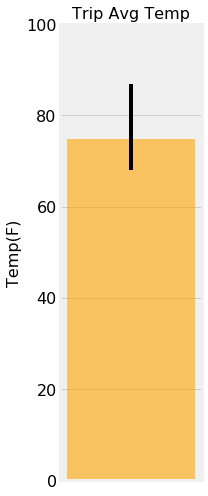

In [246]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = my_temps[0][1]
min_temp = my_temps[0][0]
max_temp = my_temps[0][2]
upper_error = max_temp - avg_temp
lower_error = avg_temp - min_temp
error_range = [[lower_error], [upper_error]]
plt.figure(figsize=(3,7))
x=np.arange(1)
plt.xticks(x,[])
plt.grid(b=True, alpha = 2.0)
plt.grid(axis='x')
plt.bar(x,avg_temp, yerr = error_range ,alpha = 0.6, color = "orange")
plt.ylim(0,100)
plt.yticks(fontsize=16)
plt.ylabel("Temp(F)", fontsize=16)
plt.title("Trip Avg Temp", fontsize=16)
plt.tight_layout()
plt.savefig('Charts/trip_temp.png')
plt.show()

In [275]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start = '2017-05-12'
end = '2017-05-23'

sel = [ME.station,ST.name,func.avg(ME.prcp),ST.latitude, ST.longitude, ST.elevation]
stn_avg = session.query(*sel).filter(ME.station == ST.station).\
filter(ME.date >= start).filter(ME.date <= end).group_by(ME.station).order_by(func.avg(ME.prcp).desc()).all()

for station in stn_avg:
    print(station)

stn_avg_df = pd.DataFrame(stn_avg, columns=['Station','Name','Prcp','Lat','Long','Elv'])
stn_avg_df

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 0.2899999999999999, 21.3331, -157.8025, 152.4)
('USC00519281', 'WAIHEE 837.5, HI US', 0.06583333333333334, 21.45167, -157.84888999999998, 32.9)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.05666666666666667, 21.5213, -157.8374, 7.0)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.052000000000000005, 21.33556, -157.71139, 19.5)
('USC00513117', 'KANEOHE 838.1, HI US', 0.030833333333333334, 21.4234, -157.8015, 14.6)
('USC00519397', 'WAIKIKI 717.2, HI US', 0.012500000000000002, 21.2716, -157.8168, 3.0)


,Station,Name,Prcp,Lat,Long,Elv
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.290000,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.065833,21.45167,-157.84889,32.9
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.056667,21.52130,-157.83740,7.0
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.052000,21.33556,-157.71139,19.5
4,USC00513117,"KANEOHE 838.1, HI US",0.030833,21.42340,-157.80150,14.6
5,USC00519397,"WAIKIKI 717.2, HI US",0.012500,21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [303]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    query = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    result = [item for temp in query for item in temp] 
    return result
daily_normals("01-01")

[62.0, 69.15384615384616, 77.0]

In [304]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_dt = dt.date(2020, 5, 12)
end_dt = dt.date(2020, 5, 23)
# Use the start and end date to create a range of dates
date_list = [start_dt + dt.timedelta(days=x) for x in range(0, (end_dt-start_dt).days)]
# Stip off the year and save a list of %m-%d strings
date_m_d = [day.strftime("%m-%d")for day in date_list]
# Loop through the list of %m-%d strings and calculate the normals for each date

normals = [daily_normals(date) for date in date_m_d]
normals

    

[[65.0, 73.13793103448276, 79.0],
 [67.0, 73.14285714285714, 79.0],
 [63.0, 73.89285714285714, 80.0],
 [63.0, 73.69090909090909, 79.0],
 [68.0, 74.37931034482759, 80.0],
 [68.0, 74.45, 79.0],
 [68.0, 74.10714285714286, 82.0],
 [65.0, 73.80701754385964, 79.0],
 [68.0, 73.89655172413794, 79.0],
 [64.0, 72.96428571428571, 80.0],
 [64.0, 74.45614035087719, 80.0]]

In [343]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norms_df = pd.DataFrame(index = date_m_d,data = normals,columns=['tmin','tavg','tmax'])
norms_df.index.name = 'date'
norms_df

,tmin,tavg,tmax
date,,,
05-12,65.0,73.137931,79.0
05-13,67.0,73.142857,79.0
05-14,63.0,73.892857,80.0
05-15,63.0,73.690909,79.0
05-16,68.0,74.379310,80.0
05-17,68.0,74.450000,79.0
05-18,68.0,74.107143,82.0
05-19,65.0,73.807018,79.0
05-20,68.0,73.896552,79.0


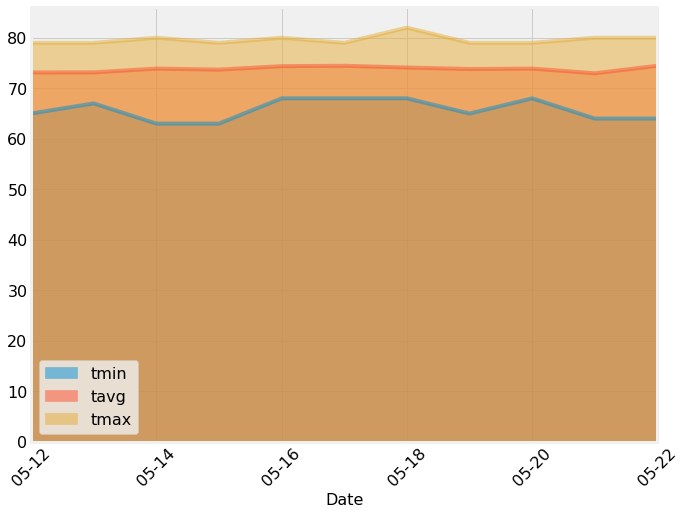

In [345]:
# Plot the daily normals as an area plot with `stacked=False`
norms_df.plot.area(stacked=False,figsize=(10,8))
plt.xlabel('Date', fontsize=16)
plt.xticks(fontsize = 16, rotation = 45)
plt.yticks(fontsize = 16)
plt.legend(loc='best', prop={'size': 16})
plt.savefig('Charts/temp_norms.png')
plt.show()
